In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brazilian-ecommerce:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F55151%2F2669146%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240527%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240527T200049Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5a8965e5985356e29e07c5882bc09d33752cb860c9e0511d57dc8cf289837d1a4fc2f4ce47f69e3b012bbb9e17ad6ba0ad93ff828e5ac64b6e3ba094489a34bfe419938ba364d99bb53aeda91a1def79504add371b4bd2ad599e82b3b684b077f0f17a3ddd12b49b657f8c538bd93844365082242381014f645647a4a2534157e1d9ffd09520f7549f06ee97471ff28d51e3feb4489c0ac2d94ee3e9b9461bd5aaf1cfa40f029c86a7c3b6c95b1dceb869f4423595473dfd960dd88364e95272a6e2ca4aa4d65568ce064f61a3370f750500183f04e0b490782a02054fd5869ba3aec1cb0171371c81f2264476aef80f5986e629b9ab1ae5ccf9d7f0f4ea056c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 44717580 bytes downloaded
Downloaded and uncompressed: brazilian-ecommerce
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv


In [4]:
# manipula√ß√£o de bases de dados
import pandas as pd

# manipula√ß√£o alg√©brica
import numpy as np

# Bibliotecas de EDA
import missingno
from summarytools import dfSummary
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Fun√ß√£o para lidar com latitudes e longitudes
from geopy.distance import geodesic

# Trazendo a fun√ß√£o para dividir em treino e teste e a fun√ß√£o para construir a valida√ß√£o cruzada
from sklearn.model_selection import train_test_split, KFold

# Importando a fun√ß√£o de feature importance
from sklearn.inspection import permutation_importance

# Importando os modelos que ser√£o utilizados
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Importando os imputers e o pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Importando a fun√ß√£o para tratar vari√°veis categ√≥ricas
from category_encoders import CatBoostEncoder

# Biblioteca para calcular as m√©tricas de regress√£o
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Biblioteca para tunagem de hiperpar√¢metros
import optuna as opt

pd.set_option('display.max_columns', None)

from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
df_orders = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
df_orders_Itens = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')
df_products = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')
df_costumers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv')
df_reviews = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv')
df_pagamentos = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv')
df_vendedores = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv')
df_geoloc = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv')

# Analise de cada dataset separadamente

## Df Orders

In [6]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


## Df Orders Itens

In [7]:
df_orders_Itens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


## Df Products

In [8]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


## Df costumers

In [9]:
df_costumers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


## Df reviews

In [10]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


## Df pagamentos

In [11]:
df_pagamentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


## Df vendedores

In [12]:
df_vendedores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


## Df Geolocaliza√ß√£o

In [13]:
df_geoloc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


# Unindo as bases de dados

In [14]:
df1 = pd.merge(df_orders, df_orders_Itens, on='order_id')

df2 = pd.merge(df1, df_products, on='product_id')

df3 = pd.merge(df2, df_costumers, on='customer_id')

df4 = pd.merge(df3, df_reviews, on='order_id')

df5 = pd.merge(df4, df_pagamentos, on='order_id')

df = pd.merge(df5, df_vendedores, on='seller_id')

In [15]:
print(f"A base possui {df.shape[0]} linhas e {df.shape[1]} colunas.")

A base possui 117329 linhas e 39 colunas.


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117329 entries, 0 to 117328
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117329 non-null  object 
 1   customer_id                    117329 non-null  object 
 2   order_status                   117329 non-null  object 
 3   order_purchase_timestamp       117329 non-null  object 
 4   order_approved_at              117314 non-null  object 
 5   order_delivered_carrier_date   116094 non-null  object 
 6   order_delivered_customer_date  114858 non-null  object 
 7   order_estimated_delivery_date  117329 non-null  object 
 8   order_item_id                  117329 non-null  int64  
 9   product_id                     117329 non-null  object 
 10  seller_id                      117329 non-null  object 
 11  shipping_limit_date            117329 non-null  object 
 12  price                         

In [17]:
df.describe()

order_item_id          price  freight_value  product_name_lenght  \
count  117329.000000  117329.000000  117329.000000        115634.000000   
mean        1.194121     120.524349      20.027514            48.768018   
std         0.684225     182.944843      15.828077            10.033831   
min         1.000000       0.850000       0.000000             5.000000   
25%         1.000000      39.900000      13.080000            42.000000   
50%         1.000000      74.900000      16.280000            52.000000   
75%         1.000000     134.900000      21.180000            57.000000   
max        21.000000    6735.000000     409.680000            76.000000   

       product_description_lenght  product_photos_qty  product_weight_g  \
count               115634.000000       115634.000000     117309.000000   
mean                   785.802861            2.205528       2110.763062   
std                    652.382965            1.717783       3785.128931   
min                      4.000000            1.000000          0.000000   
25%                    346.000000            1.000000        300.000000   
50%                    600.000000            1.000000        700.000000   
75%                    983.000000            3.000000       1800.000000   
max                   3992.000000           20.000000      40425.000000   

       product_length_cm  product_height_cm  product_width_cm  \
count      117309.000000      117309.000000     117309.000000   
mean           30.254456          16.612476         23.071452   
std            16.177519          13.452625         11.745875   
min             7.000000           2.000000          6.000000   
25%            18.000000           8.000000         15.000000   
50%            25.000000          13.000000         20.000000   
75%            38.000000          20.000000         30.000000   
max           105.000000         105.000000        118.000000   

       customer_zip_code_prefix   review_score  payment_sequential  \
count             117329.000000  117329.000000       117329.000000   
mean               35060.118112       4.031467            1.094452   
std                29849.496175       1.387927            0.731174   
min                 1003.000000       1.000000            1.000000   
25%                11250.000000       4.000000            1.000000   
50%                24240.000000       5.000000            1.000000   
75%                58770.000000       5.000000            1.000000   
max                99990.000000       5.000000           29.000000   

       payment_installments  payment_value  seller_zip_code_prefix  
count         117329.000000  117329.000000           117329.000000  
mean               2.940151     172.062565            24450.781955  
std                2.775370     265.388194            27582.364358  
min                0.000000       0.000000             1001.000000  
25%                1.000000      60.750000             6429.000000  
50%                2.000000     108.100000            13660.000000  
75%                4.000000     189.060000            28035.000000  
max               24.000000   13664.080000            99730.000000

Vamos analisar os nulos nesse nosso conjunto de dados unido

In [18]:
val_nulos = df.isnull().sum()
val_nulos_data_frame = pd.DataFrame({'Nome da Coluna':val_nulos.index,'Quantidade de valores nulos':val_nulos.values})
val_nulos_data_frame

Nome da Coluna  Quantidade de valores nulos
0                        order_id                            0
1                     customer_id                            0
2                    order_status                            0
3        order_purchase_timestamp                            0
4               order_approved_at                           15
5    order_delivered_carrier_date                         1235
6   order_delivered_customer_date                         2471
7   order_estimated_delivery_date                            0
8                   order_item_id                            0
9                      product_id                            0
10                      seller_id                            0
11            shipping_limit_date                            0
12                          price                            0
13                  freight_value                            0
14          product_category_name                         1695
15            product_name_lenght                         1695
16     product_description_lenght                         1695
17             product_photos_qty                         1695
18               product_weight_g                           20
19              product_length_cm                           20
20              product_height_cm                           20
21               product_width_cm                           20
22             customer_unique_id                            0
23       customer_zip_code_prefix                            0
24                  customer_city                            0
25                 customer_state                            0
26                      review_id                            0
27                   review_score                            0
28           review_comment_title                       103437
29         review_comment_message                        67650
30           review_creation_date                            0
31        review_answer_timestamp                            0
32             payment_sequential                            0
33                   payment_type                            0
34           payment_installments                            0
35                  payment_value                            0
36         seller_zip_code_prefix                            0
37                    seller_city                            0
38                   seller_state                            0

In [19]:
# Percentual de valores nulos

rows, columns = df.shape

percentual_nan = ((df.isnull().sum()/rows)*100).round(2)
percentual_nan

order_id                          0.00
customer_id                       0.00
order_status                      0.00
order_purchase_timestamp          0.00
order_approved_at                 0.01
order_delivered_carrier_date      1.05
order_delivered_customer_date     2.11
order_estimated_delivery_date     0.00
order_item_id                     0.00
product_id                        0.00
seller_id                         0.00
shipping_limit_date               0.00
price                             0.00
freight_value                     0.00
product_category_name             1.44
product_name_lenght               1.44
product_description_lenght        1.44
product_photos_qty                1.44
product_weight_g                  0.02
product_length_cm                 0.02
product_height_cm                 0.02
product_width_cm                  0.02
customer_unique_id                0.00
customer_zip_code_prefix          0.00
customer_city                     0.00
customer_state           

Analisaremos os valores distintos

In [20]:
# Contagem de valores distintos

contagem = pd.DataFrame(columns = ['Variavel', 'Quantidade_valores_distintos'])

for colunas in df.columns:
    dados = pd.DataFrame({'Variavel':[colunas], 'Quantidade_valores_distintos':df[colunas].value_counts().shape[0]})
    contagem = pd.concat([contagem, dados], ignore_index=True)

contagem

Variavel Quantidade_valores_distintos
0                        order_id                        97916
1                     customer_id                        97916
2                    order_status                            7
3        order_purchase_timestamp                        97370
4               order_approved_at                        89533
5    order_delivered_carrier_date                        80449
6   order_delivered_customer_date                        95021
7   order_estimated_delivery_date                          449
8                   order_item_id                           21
9                      product_id                        32789
10                      seller_id                         3090
11            shipping_limit_date                        92642
12                          price                         5948
13                  freight_value                         6976
14          product_category_name                           73
15            product_name_lenght                           66
16     product_description_lenght                         2958
17             product_photos_qty                           19
18               product_weight_g                         2200
19              product_length_cm                           99
20              product_height_cm                          102
21               product_width_cm                           95
22             customer_unique_id                        94720
23       customer_zip_code_prefix                        14955
24                  customer_city                         4108
25                 customer_state                           27
26                      review_id                        97708
27                   review_score                            5
28           review_comment_title                         4497
29         review_comment_message                        35691
30           review_creation_date                          632
31        review_answer_timestamp                        97546
32             payment_sequential                           29
33                   payment_type                            4
34           payment_installments                           24
35                  payment_value                        28831
36         seller_zip_code_prefix                         2245
37                    seller_city                          611
38                   seller_state                           23

**dfSummary(df)**

√â uma fun√ß√£o do pacote *summarytools*, que fornece uma descri√ß√£o detalhada e intuitiva de um dataframe. Esta fun√ß√£o √© muito √∫til para a an√°lise explorat√≥ria de dados (EDA) porque fornece um resumo abrangente de cada vari√°vel no dataframe, incluindo estat√≠sticas descritivas, distribui√ß√£o, presen√ßa de valores ausentes, entre outros aspectos importantes.

O que √© dfSummary(df)?

dfSummary(df) gera um resumo estat√≠stico detalhado para cada vari√°vel em um dataframe df. A sa√≠da da fun√ß√£o inclui informa√ß√µes como:

Tipo de vari√°vel (num√©rica, categ√≥rica, etc.)
Estat√≠sticas descritivas (m√©dia, mediana, m√≠nimo, m√°ximo, quartis)
Distribui√ß√£o de valores (histograma para vari√°veis num√©ricas, contagens de frequ√™ncias para vari√°veis categ√≥ricas)
Contagem e propor√ß√£o de valores ausentes (NAs)
Contagem de valores distintos (unique)
Exemplos de valores (valores principais para categ√≥ricas ou principais para num√©ricas)


Por que usar dfSummary(df)?

Usar dfSummary(df) tem v√°rias vantagens:

An√°lise Explorat√≥rio de Dados (EDA):

*   Ajuda a entender a distribui√ß√£o e a natureza dos dados em cada coluna.
Fornece uma vis√£o geral r√°pida dos dados sem a necessidade de gerar estat√≠sticas descritivas individualmente para cada vari√°vel.
Identifica√ß√£o de Problemas nos Dados:

*   Detecta valores ausentes (NAs), valores fora do intervalo esperado e outliers.
*   Identifica vari√°veis que precisam de limpeza ou transforma√ß√£o antes de an√°lise mais aprofundada.
Efici√™ncia:

*   Economiza tempo ao gerar um resumo detalhado de todas as vari√°veis em um √∫nico comando.
*   Facilita a documenta√ß√£o e a comunica√ß√£o dos insights iniciais sobre os dados.
Documenta√ß√£o e Comunica√ß√£o:

*   A sa√≠da pode ser salva em arquivos HTML, facilitando o compartilhamento com outros membros da equipe ou para inclus√£o em relat√≥rios.

Como usar dfSummary(df)?

Primeiro, √© necess√°rio instalar e carregar o pacote summarytools. Depois, basta aplicar a fun√ß√£o dfSummary ao dataframe que deseja analisar.

Exemplo de uso:



In [21]:
dfSummary(df)

In [22]:
# Dataframe com a quantidade de pedidos para cada tipo de status do pedido

order_status_counts = df['order_status'].value_counts().reset_index()
order_status_counts.columns=['status_pedido','contagem']

order_status_counts

status_pedido  contagem
0     delivered    114859
1       shipped      1167
2      canceled       553
3      invoiced       370
4    processing       370
5   unavailable         7
6      approved         3

In [23]:
payment_counts = df['payment_type'].value_counts().reset_index()
payment_counts.columns=['Tipo_pagamento', 'contagem']

payment_counts

Tipo_pagamento  contagem
0    credit_card     86520
1         boleto     22835
2        voucher      6282
3     debit_card      1692

In [24]:
fig = px.bar(payment_counts, x='Tipo_pagamento', y='contagem', color='Tipo_pagamento', text='contagem',
            title='Pedidos por tipo de pagamento', labels={'contagem':'Quantidade de Pedidos', 'Tipo_pagamento':'Tipo de Pagamento'})

fig.update_traces(textposition='outside', texttemplate='%{text}', textfont_size=12)
fig.update_layout(width=1000, height=500)
fig.show()

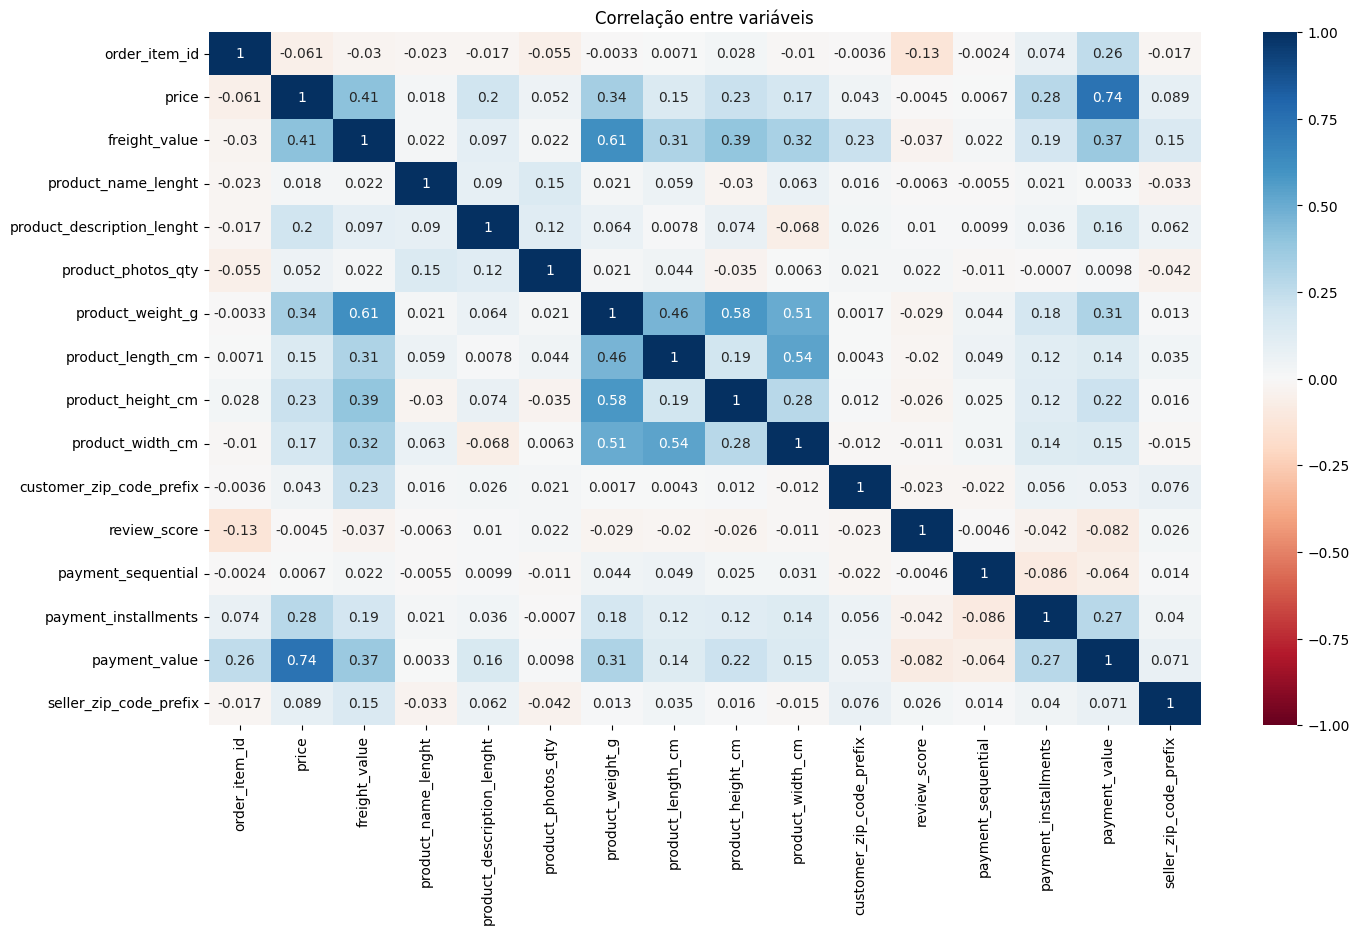

In [25]:
# Heatmap mostrando as correla√ß√µes entre vari√°veis num√©ricas

plt.figure(figsize=(16,9))
plt.title('Correla√ß√£o entre vari√°veis')

df_numeric = df.select_dtypes(include=[np.number])
sns.heatmap(df_numeric.corr(), annot=True, vmin=-1, vmax=1, cmap='RdBu')
plt.show()

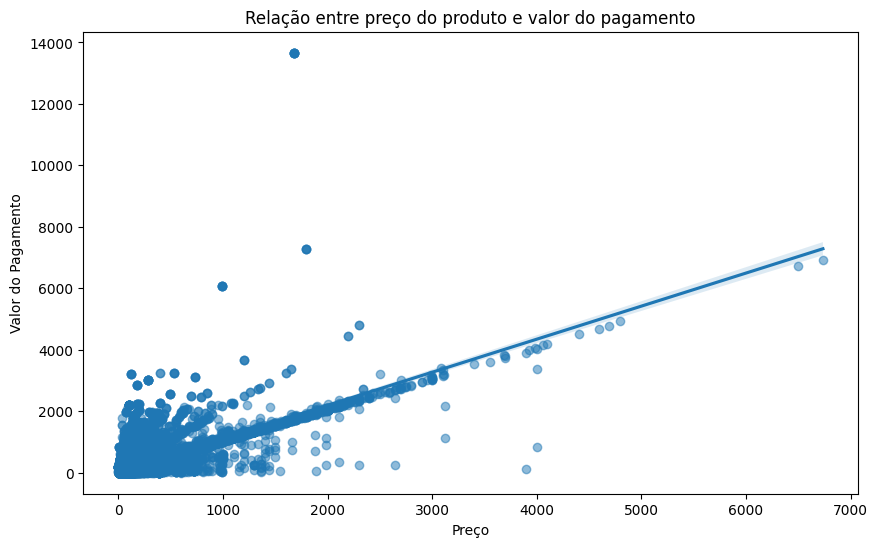

In [26]:
# Gr√°fico de dispers√£o entre pre√ßo do produto e valor pago pelo cliente

plt.figure(figsize=(10,6))
sns.regplot(x='price', y='payment_value', data=df, scatter_kws={'alpha':0.5})

plt.title('Rela√ß√£o entre pre√ßo do produto e valor do pagamento')
plt.xlabel('Pre√ßo')
plt.ylabel('Valor do Pagamento')
plt.show()

([0], [Text(0, 0, '')])

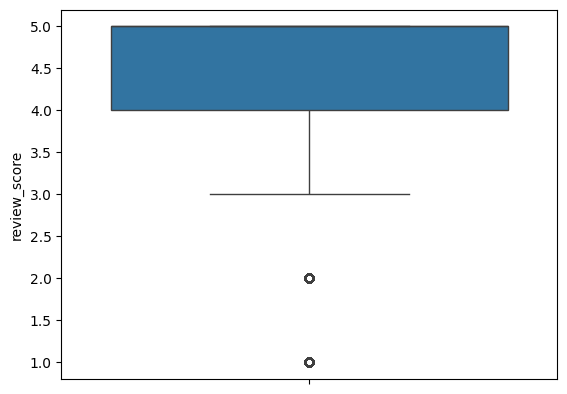

In [27]:
# An√°lise univariada dos reviews dos clientes

fig=sns.boxplot(y='review_score', data=df)
plt.xticks(rotation=90)

In [28]:
df['review_score'].describe()

count    117329.000000
mean          4.031467
std           1.387927
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: review_score, dtype: float64

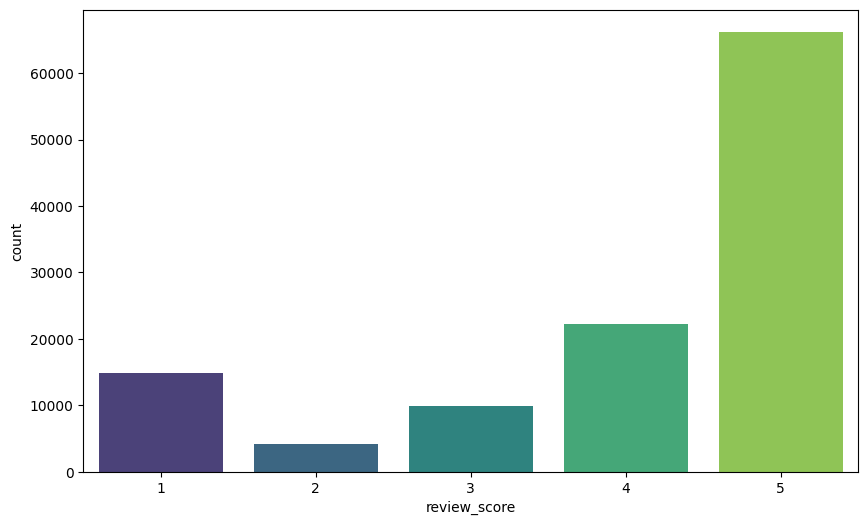

In [29]:
# Countplot da quantidade de pedidos para cada uma das notas de review

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='review_score', palette='viridis')
plt.show()

In [30]:
df['price'].describe()

count    117329.000000
mean        120.524349
std         182.944843
min           0.850000
25%          39.900000
50%          74.900000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

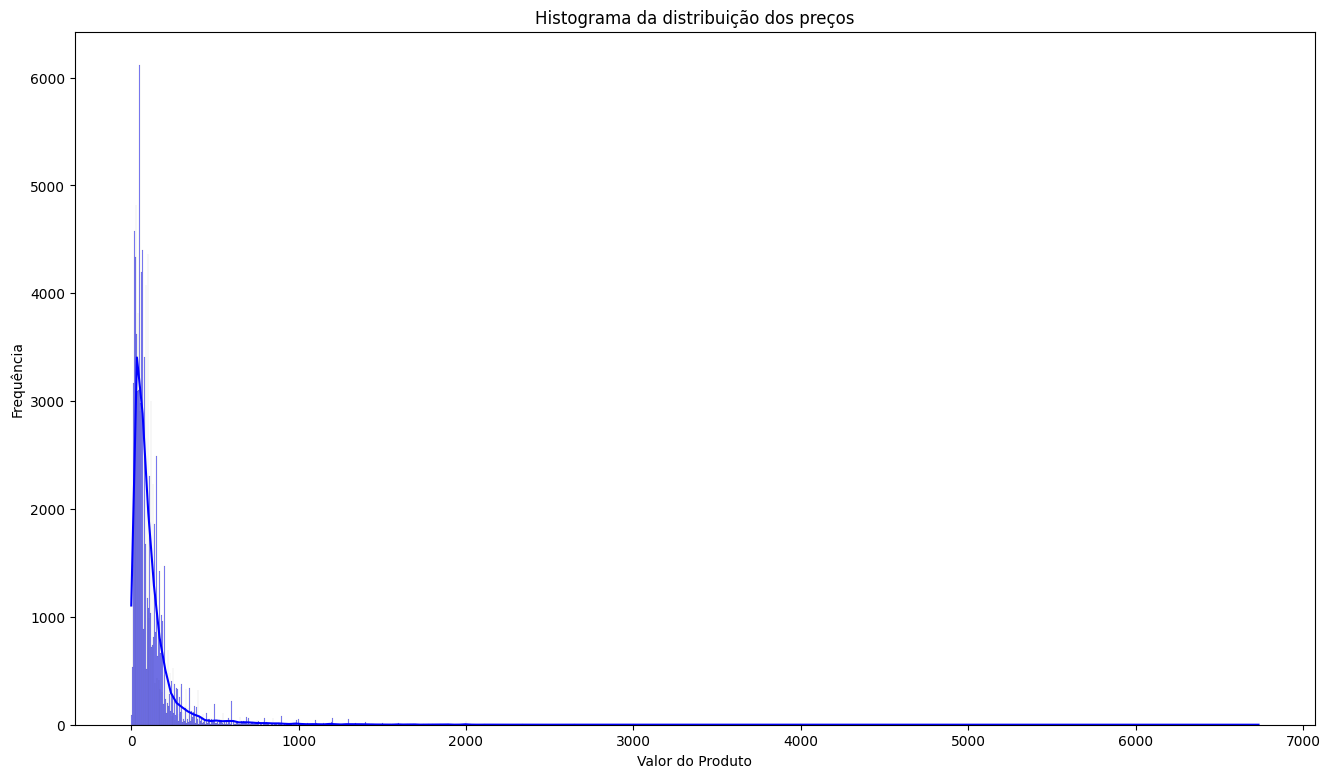

In [31]:
# Histograma da distribui√ß√£o dos pre√ßos dos produtos

plt.figure(figsize=(16,9))
sns.histplot(x='price', data=df, color='blue', kde=True)
plt.title('Histograma da distribui√ß√£o dos pre√ßos')
plt.xlabel('Valor do Produto')
plt.ylabel('Frequ√™ncia')
plt.show()

([0], [Text(0, 0, '')])

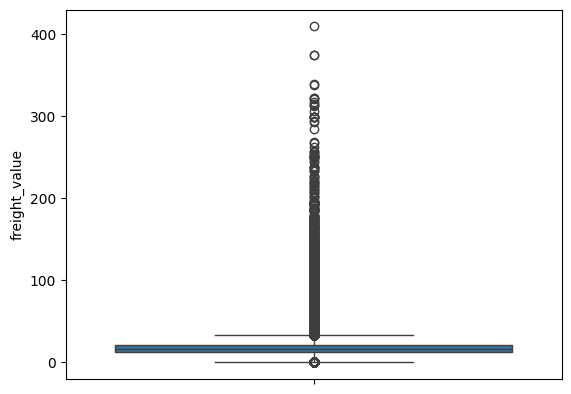

In [32]:
# An√°lise univariada do valor do frete

fig=sns.boxplot(y='freight_value', data=df)
plt.xticks(rotation=90)

In [33]:
df['freight_value'].describe()

count    117329.000000
mean         20.027514
std          15.828077
min           0.000000
25%          13.080000
50%          16.280000
75%          21.180000
max         409.680000
Name: freight_value, dtype: float64

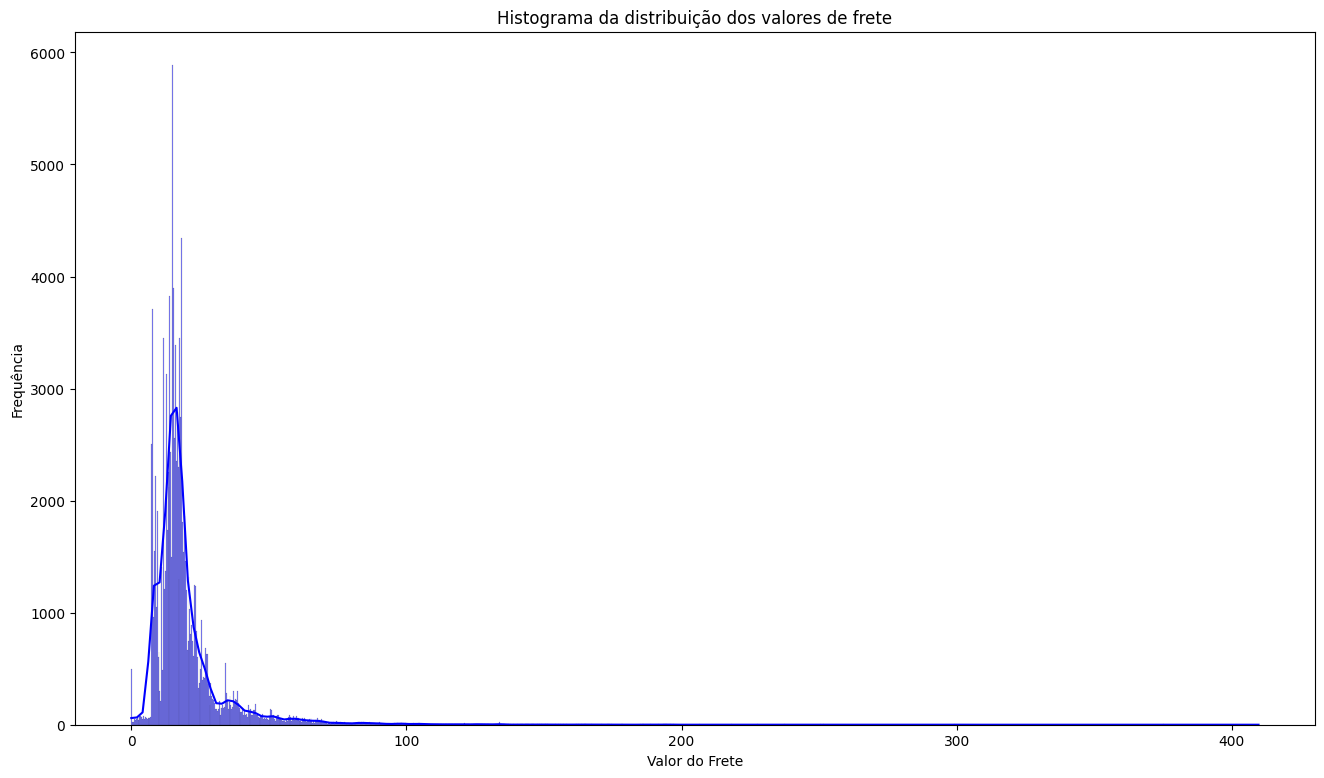

In [34]:
# Histograma da distribui√ß√£o de valores de frete

plt.figure(figsize=(16,9))
sns.histplot(x='freight_value', data=df, color='blue', kde=True)
plt.title('Histograma da distribui√ß√£o dos valores de frete')
plt.xlabel('Valor do Frete')
plt.ylabel('Frequ√™ncia')
plt.show()

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'delivered'),
  Text(1, 0, 'shipped'),
  Text(2, 0, 'canceled'),
  Text(3, 0, 'invoiced'),
  Text(4, 0, 'processing'),
  Text(5, 0, 'unavailable'),
  Text(6, 0, 'approved')])

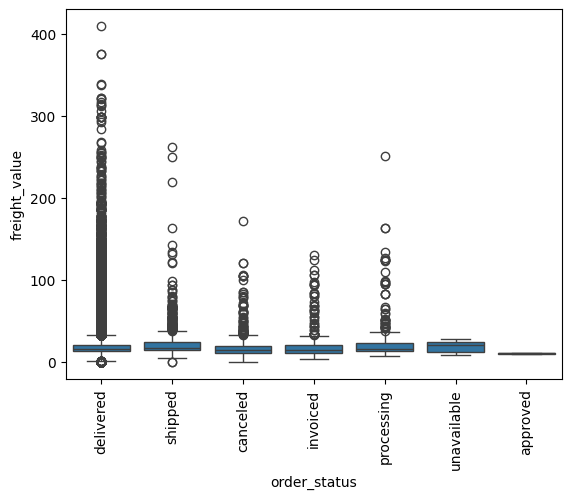

In [35]:
fig=sns.boxplot(x = 'order_status',y='freight_value', data=df)
plt.xticks(rotation=90)

In [36]:
# Criando variavel do volume
df['Volume'] = df['product_length_cm']*df['product_height_cm']*df['product_width_cm']
# Criando a variavel da densidade
df['densidade'] = df['product_weight_g']/df['Volume']

In [37]:
# Criando coluna velocidade de entrega

df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

df['Velocidade_entrega_real'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
df['Velocidade_entrega_estimada'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.days

In [38]:
# Cria√ß√£o da velocidade de aprova√ß√£o do pedido
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])

df['velocidade_processamento'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.days

In [39]:
df_geoloc.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP

In [40]:
geolocation_agregado = df_geoloc.groupby('geolocation_zip_code_prefix').agg({'geolocation_lat':'mean','geolocation_lng':'mean'}).reset_index()
geolocation_agregado.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng
0                         1001       -23.550190       -46.634024
1                         1002       -23.548146       -46.634979
2                         1003       -23.548994       -46.635731
3                         1004       -23.549799       -46.634757
4                         1005       -23.549456       -46.636733

In [41]:
# Trazendo latitude e longitude dos vendedores
df=pd.merge(df, geolocation_agregado, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')
df.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
4  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3    delivered      2017-08-15 18:29:31 2017-08-15 20:05:16   
4    delivered      2017-08-02 18:24:47 2017-08-02 18:43:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2017-08-17 15:28:33           2017-08-18 14:44:43   
4          2017-08-04 17:35:43           2017-08-07 18:30:01   

  order_estimated_delivery_date  order_item_id  \
0                    2017-10-18              1   
1                    2017-10-18              1   
2                    2017-10-18              1   
3                    2017-08-28              1   
4                    2017-08-15              1   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
2  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
3  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
4  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   

   shipping_limit_date  price  freight_value  product_category_name  \
0  2017-10-06 11:07:15  29.99           8.72  utilidades_domesticas   
1  2017-10-06 11:07:15  29.99           8.72  utilidades_domesticas   
2  2017-10-06 11:07:15  29.99           8.72  utilidades_domesticas   
3  2017-08-21 20:05:16  29.99           7.78  utilidades_domesticas   
4  2017-08-08 18:37:31  29.99           7.78  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       268.0                 4.0   
1                 40.0                       268.0                 4.0   
2                 40.0                       268.0                 4.0   
3                 40.0                       268.0                 4.0   
4                 40.0                       268.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             500.0               19.0                8.0              13.0   
1             500.0               19.0                8.0              13.0   
2             500.0               19.0                8.0              13.0   
3             500.0               19.0                8.0              13.0   
4             500.0               19.0                8.0              13.0   

                 customer_unique_id  customer_zip_code_prefix customer_city  \
0  7c396fd4830fd04220f754e42b4e5bff                      3149     sao paulo   
1  7c396fd4830fd04220f754e42b4e5bff                      3149     sao paulo   
2  7c396fd4830fd04220f754e42b4e5bff                      3149     sao paulo   
3  3a51803cc0d012c3b5dc8b7528cb05f7                      3366     sao paulo   
4  ef0996a1a279c26e7ecbd737be23d235                      2290     sao paulo   

  customer_state                         review_id  review_score  \
0             SP  a54f0611adc9ed256b57ede6b6eb5114             4   
1             SP  a54f0611adc9ed256b57ede6b6eb5114             4   
2             SP  a54f0611adc9ed256b57ede6b6eb5114        

In [42]:
# Renomeando e excluindo colunas desnecess√°rias
df.rename(columns={'geolocation_lat':'seller_lat', 'geolocation_lng':'seller_lng'}, inplace=True)
df.drop(columns='geolocation_zip_code_prefix', inplace=True)

In [43]:
# Trazendo latitude e longitude dos compradores
df=pd.merge(df, geolocation_agregado, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')
df.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  70b35acffdf851e782ebf6fbc35eb620  8e8ee9b08afb49b080d193f98b0505af   
4  70b35acffdf851e782ebf6fbc35eb620  8e8ee9b08afb49b080d193f98b0505af   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3    delivered      2018-03-22 17:23:21 2018-03-22 18:05:36   
4    delivered      2018-03-22 17:23:21 2018-03-22 18:05:36   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-03-23 18:03:03           2018-03-25 17:22:41   
4          2018-03-23 18:03:03           2018-03-25 17:22:41   

  order_estimated_delivery_date  order_item_id  \
0                    2017-10-18              1   
1                    2017-10-18              1   
2                    2017-10-18              1   
3                    2018-04-04              1   
4                    2018-04-04              2   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
2  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
3  6cc44821f36f3156c782da72dd634e47  da8622b14eb17ae2831f4ac5b9dab84a   
4  6cc44821f36f3156c782da72dd634e47  da8622b14eb17ae2831f4ac5b9dab84a   

   shipping_limit_date  price  freight_value  product_category_name  \
0  2017-10-06 11:07:15  29.99           8.72  utilidades_domesticas   
1  2017-10-06 11:07:15  29.99           8.72  utilidades_domesticas   
2  2017-10-06 11:07:15  29.99           8.72  utilidades_domesticas   
3  2018-03-28 18:05:36  99.90          11.79        cama_mesa_banho   
4  2018-03-28 18:05:36  99.90          11.79        cama_mesa_banho   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       268.0                 4.0   
1                 40.0                       268.0                 4.0   
2                 40.0                       268.0                 4.0   
3                 55.0                       273.0                 1.0   
4                 55.0                       273.0                 1.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             500.0               19.0                8.0              13.0   
1             500.0               19.0                8.0              13.0   
2             500.0               19.0                8.0              13.0   
3            1050.0               38.0               10.0              38.0   
4            1050.0               38.0               10.0              38.0   

                 customer_unique_id  customer_zip_code_prefix customer_city  \
0  7c396fd4830fd04220f754e42b4e5bff                      3149     sao paulo   
1  7c396fd4830fd04220f754e42b4e5bff                      3149     sao paulo   
2  7c396fd4830fd04220f754e42b4e5bff                      3149     sao paulo   
3  8a4002923e801e3120a11070fd31c9e2                      3149     sao paulo   
4  8a4002923e801e3120a11070fd31c9e2                      3149     sao paulo   

  customer_state                         review_id  review_score  \
0             SP  a54f0611adc9ed256b57ede6b6eb5114             4   
1             SP  a54f0611adc9ed256b57ede6b6eb5114             4   
2             SP  a54f0611adc9ed256b57ede6b6eb5114        

In [44]:
# Renomeando e excluindo colunas desnecess√°rias
df.rename(columns={'geolocation_lat':'customer_lat', 'geolocation_lng':'customer_lng'}, inplace=True)
df.drop(columns='geolocation_zip_code_prefix', inplace=True)

In [45]:
# Calculando a dist√¢ncia entre vendedor e comprador

def calcular_distancia(dataframe):
    seller_coordenadas = (dataframe['seller_lat'], dataframe['seller_lng'])
    customer_coordenadas = (dataframe['customer_lat'], dataframe['customer_lng'])

    return geodesic(seller_coordenadas, customer_coordenadas).kilometers

df['distancia'] = df.apply(calcular_distancia, axis=1)

In [46]:
df.drop(columns=['seller_lat','seller_lng','customer_lat','customer_lng'], inplace=True)

In [47]:
# Obtendo m√™s de compra e dia da semana da compra
df['mes_compra'] = df['order_purchase_timestamp'].dt.month

df['dia_semana_compra'] = df['order_purchase_timestamp'].dt.dayofweek

In [48]:
# Trazendo informa√ß√£o da √©poca do ano

df['black_friday'] = ((df['mes_compra'] == 11) & (df['dia_semana_compra'] == 4) & (df['order_purchase_timestamp'].dt.day >= 20) & (df['order_purchase_timestamp'].dt.day <= 30)).astype(int)
df['natal'] = ((df['mes_compra'] == 12) & (df['order_purchase_timestamp'].dt.day >= 1) & (df['order_purchase_timestamp'].dt.day <= 25)).astype(int)

In [49]:
# Removendo as colunas desnecess√°rias
colunas_para_remover = ['order_id', 'customer_id', 'product_id', 'seller_id', 'order_status', 'order_purchase_timestamp',
                       'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
                       'order_estimated_delivery_date', 'shipping_limit_date', 'product_description_lenght',
                       'product_name_lenght', 'product_photos_qty', 'customer_unique_id', 'review_id', 'review_comment_title',
                       'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
                       'payment_type', 'payment_installments', 'payment_value', 'seller_zip_code_prefix', 'order_item_id']

df.drop(columns=colunas_para_remover, inplace=True)
df.drop(columns='customer_zip_code_prefix', inplace=True)

In [50]:
df[df.duplicated()]

price  freight_value     product_category_name  product_weight_g  \
1        29.99           8.72     utilidades_domesticas             500.0   
2        29.99           8.72     utilidades_domesticas             500.0   
4        99.90          11.79           cama_mesa_banho            1050.0   
15       34.90          20.84     utilidades_domesticas            3700.0   
76      102.90           9.64  tablets_impressao_imagem             450.0   
...        ...            ...                       ...               ...   
116727  159.90          12.14                     bebes            2200.0   
116740  960.00          82.51         moveis_escritorio              50.0   
116743  109.90          19.96                     bebes             800.0   
116744  109.90          19.96                     bebes             800.0   
116745  109.90          19.96                     bebes             800.0   

        product_length_cm  product_height_cm  product_width_cm  \
1                    19.0                8.0              13.0   
2                    19.0                8.0              13.0   
4                    38.0               10.0              38.0   
15                   32.0               22.0              46.0   
76                   25.0                5.0              20.0   
...                   ...                ...               ...   
116727               16.0               35.0              49.0   
116740               35.0               90.0              45.0   
116743               32.0               11.0              27.0   
116744               32.0               11.0              27.0   
116745               32.0               11.0              27.0   

               customer_city customer_state  review_score seller_city  \
1                  sao paulo             SP             4        maua   
2                  sao paulo             SP             4        maua   
4                  sao paulo             SP             5  piracicaba   
15             florianopolis             SC             5     limeira   
76                  campinas             SP             5      santos   
...                      ...            ...           ...         ...   
116727  itapecerica da serra             SP             5        maua   
116740               biguacu             SC             1     lajeado   
116743             sao paulo             SP             5    camboriu   
116744             sao paulo             SP             5    camboriu   
116745             sao paulo             SP             5    camboriu   

       seller_state    Volume  densidade  Velocidade_entrega_real  \
1                SP    1976.0   0.253036                      8.0   
2                SP    1976.0   0.253036                      8.0   
4                SP   14440.0   0.072715                      2.0   
15               SP   32384.0   0.114254                      8.0   
76               SP    2500.0   0.180000                      8.0   
...             ...       ...        ...                      ...   
116727           SP   27440.0   0.080175                      4.0   
116740           RS  141750.0   0.000353                      NaN   
116743           SC    9504.0   0.084175                      8.0   
116744           SC    9504.0   0.084175                      8.0   
116745           SC    9504.0   0.084175                      8.0   

        Velocidade_entrega_estimada  velocidade_processamento   distancia  \
1                                15                       0.0   18.566632   
2                                15                       0.0   18.566632   
4                                12                       0.0  146.370789   
15                               27                       0.0  556.788540   
76                               10                       0.0  136.727155   
...                             ...                       ...         ...   
116727                            9           

In [51]:
df = df.drop_duplicates()

# Modelagem

In [52]:
# Dividindo em X e y
X = df.drop(columns='freight_value', axis=1)
y = df.freight_value

In [53]:
# Divis√£o em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [54]:
# Modelos instanciados

modelo_XGBoost = XGBRegressor(n_estimators = 1000, max_depth = 8, learning_rate = 1e-3, n_jobs = -1, random_state = 0)
modelo_LightGBM = LGBMRegressor(n_estimators = 1000, max_depth = 8, num_leaves = 2^8, learning_rate = 1e-3, n_jobs = -1, verbose = -1, random_state = 0)
modelo_catboost = CatBoostRegressor(n_estimators = 1000, max_depth = 8, learning_rate = 1e-3, random_state = 0, verbose = 0)
modelo_decision_tree = DecisionTreeRegressor(random_state = 0, max_depth = 8, min_samples_split = 2)

In [58]:
# Aplicando o Feature importance

# Instanciando o catboost encoder para vari√°veis categ√≥ricas

encoder = CatBoostEncoder()

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for col in X_train_encoded.select_dtypes(include=['object']).columns:

    # Tratando a vari√°vel categ√≥rica
    X_train_encoded[col] = encoder.fit_transform(X_train_encoded[col], y_train)
    X_test_encoded[col] = encoder.transform(X_test_encoded[col])

# Treinando o modelo
modelo_XGBoost.fit(X_train_encoded, y_train)

r = permutation_importance(modelo_XGBoost, X_test_encoded, y_test, n_repeats = 30, random_state = 0)



In [60]:
# Criando um dataframe para mostrar as import√¢ncias de cada vari√°vel
importances = pd.DataFrame({'Feature':X_test_encoded.columns, 'importance':r.importances_mean})

# Ordenando as vari√°veis pela import√¢ncia
importances = importances.sort_values(by='importance', ascending=False)
importances

Feature    importance
11                       Volume  2.186482e-01
16                    distancia  2.016445e-01
2              product_weight_g  1.794451e-01
0                         price  8.716159e-02
7                customer_state  2.794657e-02
9                   seller_city  2.190611e-02
3             product_length_cm  1.578133e-02
5              product_width_cm  1.193465e-02
10                 seller_state  1.174848e-02
12                    densidade  8.866938e-03
6                 customer_city  3.712711e-03
17                   mes_compra  2.592953e-03
14  Velocidade_entrega_estimada  2.118856e-03
4             product_height_cm  7.582215e-04
13      Velocidade_entrega_real  3.744513e-04
1         product_category_name  3.389412e-04
15     velocidade_processamento  2.662822e-04
19                 black_friday -1.031069e-07
20                        natal -1.043524e-05
18            dia_semana_compra -2.765538e-04
8                  review_score -4.353148e-04

In [61]:
# Definindo as colunas menos importantes com base no Feature Importance
colunas_menos_importantes = ['review_score', 'dia_semana_compra', 'natal', 'product_category_name', 'black_friday']

# Excluindo as colunas menos importantes
X_train = X_train.drop(columns = colunas_menos_importantes)
X_test = X_test.drop(columns = colunas_menos_importantes)

In [62]:
# Aplicando o Feature importance

# Instanciando o catboost encoder para vari√°veis categ√≥ricas
encoder = CatBoostEncoder()

X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for col in X_train_encoded.select_dtypes(include=['object']).columns:

    # Tratando a vari√°vel categ√≥rica
    X_train_encoded[col] = encoder.fit_transform(X_train_encoded[col], y_train)
    X_test_encoded[col] = encoder.transform(X_test_encoded[col])

# Treinando o modelo
modelo_XGBoost.fit(X_train_encoded, y_train)

r_versao_2 = permutation_importance(modelo_XGBoost, X_test_encoded, y_test, n_repeats = 30, random_state = 0)

In [63]:
# Criando um dataframe para mostrar as import√¢ncias de cada vari√°vel
importances_2 = pd.DataFrame({'Feature':X_test_encoded.columns, 'importance':r_versao_2.importances_mean})

# Ordenando as vari√°veis pela import√¢ncia
importances_2 = importances_2.sort_values(by='importance', ascending=False)
importances_2

Feature  importance
9                        Volume    0.221236
14                    distancia    0.205072
1              product_weight_g    0.183147
0                         price    0.089023
6                customer_state    0.029337
7                   seller_city    0.023364
2             product_length_cm    0.018699
8                  seller_state    0.012728
4              product_width_cm    0.010931
10                    densidade    0.007392
5                 customer_city    0.004278
15                   mes_compra    0.003116
3             product_height_cm    0.001642
12  Velocidade_entrega_estimada    0.001334
11      Velocidade_entrega_real    0.000481
13     velocidade_processamento    0.000318

In [64]:
k = 5

folds = KFold(n_splits = k, shuffle = True, random_state = 42)

# Criando listas para armazenar os valores das m√©tricas em cada fold
erros_absolutos = list()
erros_quadrados = list()
r2 = list()

# Ser√° aplicado o m√©todo "split" no objeto folds, que retornar√° uma lista
# com os √≠ndices das inst√¢ncias que pertencem ao conjunto de treino e
# outra com os √≠ndices das inst√¢ncias que pertencem ao conjunto de teste

for k, (train_index, test_index) in enumerate(folds.split(X, y)):

    print("#-"*8 + f"Fold: {k+1}" + "-#"*8)

    # Dividindo os dados em treino e teste para cada um dos folds
    X_train_interno, y_train_interno = X.iloc[train_index, :], y.iloc[train_index]
    X_test_interno, y_test_interno = X.iloc[test_index, :], y.iloc[test_index]
    # train_index e test_index: S√£o os √≠ndices das inst√¢ncias do conjunto
    # de treino e teste, respectivamente, selecionados em cada um dos folds

    # Instanciando o CatBoost Encoder
    encoder = CatBoostEncoder()

    # Criando um imputer para preencher com a moda os valores faltantes de vari√°veis categ√≥ricas
    cat_imputer = SimpleImputer(strategy='most_frequent')

    # Criando um imputer para preencher com a mediana os valores faltantes de vari√°veis num√©ricas
    num_imputer = SimpleImputer(strategy='median')

    # Criando pipelines para vari√°veis categ√≥ricas e num√©ricas que preenche os valores faltantes
    cat_pipeline = Pipeline([('encoder', encoder), ('imputer', cat_imputer)])
    num_pipeline = Pipeline([('imputer', num_imputer)])

    # Definindo quem s√£o as vari√°veis categ√≥ricas e num√©ricas
    cat_cols = X_train_interno.select_dtypes(include=['object']).columns
    num_cols = X_train_interno.select_dtypes(exclude=['object']).columns

    # Aplicando os pipelines no conjunto de treinamento para preencher valores faltantes em colunas categ√≥ricas e num√©ricas
    X_train_interno[cat_cols] = cat_pipeline.fit_transform(X_train_interno[cat_cols], y_train_interno)
    X_train_interno[num_cols] = num_pipeline.fit_transform(X_train_interno[num_cols])

    # Aplicando os pipelines ao conjunto de teste para preencher valores faltantes em colunas categ√≥ricas e num√©ricas
    X_test_interno[cat_cols] = cat_pipeline.transform(X_test_interno[cat_cols])
    X_test_interno[num_cols] = num_pipeline.transform(X_test_interno[num_cols])

    # Treinando o modelo
    modelo_XGBoost.fit(X_train_interno, y_train_interno)

    # Obtendo as previs√µes do modelo
    y_pred = modelo_XGBoost.predict(X_test_interno)

    # Calculando as m√©tricas para o fold em quest√£o
    r2score = r2_score(y_test_interno, y_pred)
    mse = mean_squared_error(y_test_interno, y_pred)
    mae = mean_absolute_error(y_test_interno, y_pred)

    # Armazenando as m√©tricas nas listas criadas
    erros_absolutos.append(mae)
    erros_quadrados.append(mse)
    r2.append(r2score)

    # Exibindo as m√©tricas para cada um dos folds
    print(f"MAE: {mae:.3f}")
    print(f"MSE: {mse:.3f}")
    print(f"R2: {r2score:.3f}")

#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
MAE: 5.139
MSE: 98.630
R2: 0.605
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
MAE: 5.212
MSE: 103.158
R2: 0.608
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
MAE: 5.246
MSE: 100.728
R2: 0.605
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
MAE: 5.258
MSE: 101.303
R2: 0.609
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#
MAE: 5.237
MSE: 97.955
R2: 0.586


In [65]:
# Inserir o c√°lculo das m√©dias

# Transformando as listas erros_absolutos, erros_quadrados e r2 em arrays, para fazer opera√ß√µes matem√°tica
erros_absolutos = np.array(erros_absolutos)
erros_quadrados = np.array(erros_quadrados)
r2 = np.array(r2)

# Calculando a m√©dia de todas as m√©tricas
media_mae = np.mean(erros_absolutos)
media_mse = np.mean(erros_quadrados)
media_r2 = np.mean(r2)

# Calculando o desvio padr√£o de todas as m√©tricas
std_mae = np.std(erros_absolutos)
std_mse = np.std(erros_quadrados)
std_r2 = np.std(r2)

print("#-"*6 + "Exibindo a m√©dia das m√©tricas obtidas" + "-#"*6)
print(f"M√©dia do MAE: {media_mae:.3f} +/- {std_mae:.3f}")
print(f"M√©dia do MSE: {media_mse:.3f} +/- {std_mse:.3f}")
print(f"M√©dia do R2: {media_r2:.3f} +/- {std_r2:.3f}")

#-#-#-#-#-#-Exibindo a m√©dia das m√©tricas obtidas-#-#-#-#-#-#
M√©dia do MAE: 5.218 +/- 0.043
M√©dia do MSE: 100.355 +/- 1.878
M√©dia do R2: 0.603 +/- 0.008


In [66]:
def validacao_cruzada(X, y, modelo, k):

    folds = KFold(n_splits = k, shuffle = True, random_state = 42)

    # Criando listas para armazenar os valores das m√©tricas em cada fold
    erros_absolutos = list()
    erros_quadrados = list()
    r2 = list()

    # Ser√° aplicado o m√©todo "split" no objeto folds, que retornar√° uma lista
    # com os √≠ndices das inst√¢ncias que pertencem ao conjunto de treino e
    # outra com os √≠ndices das inst√¢ncias que pertencem ao conjunto de teste
    for k, (train_index, test_index) in enumerate(folds.split(X, y)):

        print("#-"*8 + f"Fold: {k+1}" + "-#"*8)

        # Dividindo os dados em treino e teste para cada um dos folds
        X_train_interno, y_train_interno = X.iloc[train_index, :], y.iloc[train_index]
        X_test_interno, y_test_interno = X.iloc[test_index, :], y.iloc[test_index]
        # train_index e test_index: S√£o os √≠ndices das inst√¢ncias do conjunto
        # de treino e teste, respectivamente, selecionados em cada um dos folds

        # Instanciando o CatBoost Encoder
        encoder = CatBoostEncoder()

        # Criando um imputer para preencher com a moda os valores faltantes de vari√°veis categ√≥ricas
        cat_imputer = SimpleImputer(strategy='most_frequent')

        # Criando um imputer para preencher com a mediana os valores faltantes de vari√°veis num√©ricas
        num_imputer = SimpleImputer(strategy='median')

        # Criando pipelines para vari√°veis categ√≥ricas e num√©ricas que preenche os valores faltantes
        cat_pipeline = Pipeline([('encoder', encoder), ('imputer', cat_imputer)])
        num_pipeline = Pipeline([('imputer', num_imputer)])

        # Definindo quem s"ao as vari√£veis num~ericas e categ√≥ricas
        cat_cols = X_train_interno.select_dtypes(include=['object']).columns
        num_cols = X_train_interno.select_dtypes(exclude=['object']).columns

        # Aplicando os pipelines no conjunto de treinamento para preencher valores faltantes em colunas categ√≥ricas e num√©ricas
        X_train_interno[cat_cols] = cat_pipeline.fit_transform(X_train_interno[cat_cols], y_train_interno)
        X_train_interno[num_cols] = num_pipeline.fit_transform(X_train_interno[num_cols])

        # Aplicando os pipelines ao conjunto de teste para preencher valores faltantes em colunas categ√≥ricas e num√©ricas
        X_test_interno[cat_cols] = cat_pipeline.transform(X_test_interno[cat_cols])
        X_test_interno[num_cols] = num_pipeline.transform(X_test_interno[num_cols])

        # Treinando o modelo
        modelo.fit(X_train_interno, y_train_interno)

        # Obtendo as previs√µes do modelo
        y_pred = modelo.predict(X_test_interno)

        # Calculando as m√©tricas para o fold em quest√£o
        r2score = r2_score(y_test_interno, y_pred)
        mse = mean_squared_error(y_test_interno, y_pred)
        mae = mean_absolute_error(y_test_interno, y_pred)

        # Armazenando as m√©tricas nas listas criadas
        erros_absolutos.append(mae)
        erros_quadrados.append(mse)
        r2.append(r2score)

        # Exibindo as m√©tricas para cada um dos folds
        print(f"MAE: {mae:.3f}")
        print(f"MSE: {mse:.3f}")
        print(f"R2: {r2score:.3f}")

    # Transformando as listas erros_absolutos, erros_quadrados e r2 em arrays, para fazer opera√ß√µes matem√°ticas
    erros_absolutos = np.array(erros_absolutos)
    erros_quadrados = np.array(erros_quadrados)
    r2 = np.array(r2)

    # Calculando a m√©dia de todas as m√©tricas
    media_mae = np.mean(erros_absolutos)
    media_mse = np.mean(erros_quadrados)
    media_r2 = np.mean(r2)

    # Calculando o desvio padr√£o de todas as m√©tricas
    std_mae = np.std(erros_absolutos)
    std_mse = np.std(erros_quadrados)
    std_r2 = np.std(r2)

    print("#-"*6 + "Exibindo a m√©dia das m√©tricas obtidas" + "-#"*6)
    print(f"M√©dia do MAE: {media_mae:.3f} +/- {std_mae:.3f}")
    print(f"M√©dia do MSE: {media_mse:.3f} +/- {std_mse:.3f}")
    print(f"M√©dia do R2: {media_r2:.3f} +/- {std_r2:.3f}")

## Modelo XGBoost

O que √© o Modelo XGBoost?

XGBoost (Extreme Gradient Boosting) √© uma implementa√ß√£o otimizada do algoritmo de gradient boosting, projetada para desempenho, efici√™ncia e velocidade.

√â amplamente utilizado em competi√ß√µes de aprendizado de m√°quina e em aplica√ß√µes do mundo real devido √† sua capacidade de gerar modelos altamente precisos. XGBoost faz parte de uma classe de algoritmos de aprendizado de m√°quina conhecidos como boosting, que combinam o poder preditivo de v√°rios modelos fracos (tipicamente √°rvores de decis√£o) para formar um modelo robusto.

Caracter√≠sticas Principais do XGBoost:

Gradient Boosting, baseia-se no princ√≠pio de adicionar modelos novos que corrigem os erros dos modelos anteriores. Isso √© feito treinando o novo modelo nos res√≠duos (erros) dos modelos anteriores.

*   Regulariza√ß√£o, que inclui t√©cnicas de regulariza√ß√£o (L1 e L2) que ajudam a prevenir o overfitting, tornando o modelo mais generaliz√°vel.

*   Paralelismo, suporta computa√ß√£o paralela durante o treinamento, o que acelera significativamente o tempo de treinamento.
Suporte a Falhas: √â robusto a falhas e pode continuar o treinamento de onde parou.
*   √Årvores de Decis√£o, usa √°rvores de decis√£o como modelos fracos, especificamente construindo √°rvores por n√≠vel para otimizar a efici√™ncia.

Por que usar um Modelo XGBoost?

*   Alta Precis√£o, XGBoost √© conhecido por fornecer alta precis√£o em tarefas de classifica√ß√£o e regress√£o. Ele frequentemente vence competi√ß√µes de aprendizado de m√°quina.
*   Efici√™ncia Computacional, √© altamente eficiente em termos de tempo de computa√ß√£o, gra√ßas ao seu design otimizado e suporte a paralelismo.
*   Regulariza√ß√£o, a inclus√£o de regulariza√ß√£o ajuda a evitar o overfitting, um problema comum em modelos de aprendizado de m√°quina complexos.
*   Flexibilidade, pode ser usado para uma variedade de tarefas de aprendizado supervisionado, como classifica√ß√£o, regress√£o e ranking.
*   Customizabilidade, oferece uma ampla gama de par√¢metros ajust√°veis que permitem aos usu√°rios otimizar o modelo para suas necessidades espec√≠ficas.
*   Escalabilidade, pode ser usado em datasets grandes, sendo escal√°vel e eficiente em termos de mem√≥ria.


Quando Usar o XGBoost?

*   Competi√ß√£o de Aprendizado de M√°quina, ideal para competi√ß√µes onde a precis√£o do modelo √© crucial.
*   Projetos com Grande Volume de Dados, quando se est√° trabalhando com grandes datasets e precisa de um modelo eficiente e r√°pido.
*   Tarefas de Alta Variabilidade, para tarefas onde os dados s√£o complexos e vari√°veis, e um modelo robusto √© necess√°rio para capturar padr√µes sutis.
Preven√ß√£o de Overfitting, quando voc√™ precisa de um modelo que possa generalizar bem para novos dados, evitando o overfitting.

Implementa√ß√£o do Modelo XGBoost:

In [67]:
validacao_cruzada(X, y, modelo_XGBoost, k=5)

#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
MAE: 5.139
MSE: 98.630
R2: 0.605
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
MAE: 5.212
MSE: 103.158
R2: 0.608
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
MAE: 5.246
MSE: 100.728
R2: 0.605
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
MAE: 5.258
MSE: 101.303
R2: 0.609
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#
MAE: 5.237
MSE: 97.955
R2: 0.586
#-#-#-#-#-#-Exibindo a m√©dia das m√©tricas obtidas-#-#-#-#-#-#
M√©dia do MAE: 5.218 +/- 0.043
M√©dia do MSE: 100.355 +/- 1.878
M√©dia do R2: 0.603 +/- 0.008


## Modelo LightGBM

O que √© o Modelo LightGBM?

LightGBM (Light Gradient Boosting Machine) √© um framework de aprendizado de m√°quina baseado no algoritmo de gradient boosting, desenvolvido pela Microsoft. Ele foi projetado para ser eficiente e escal√°vel, especialmente para lidar com grandes volumes de dados e altos valores de caracter√≠sticas. LightGBM √© conhecido por sua velocidade de treinamento r√°pida e capacidade de gerar modelos de alta precis√£o.

Caracter√≠sticas Principais do LightGBM:

*    Gradient Boosting, assim como XGBoost, LightGBM utiliza gradient boosting para combinar o poder preditivo de v√°rios modelos fracos (√°rvores de decis√£o) e formar um modelo robusto.
*    Crescimento da √Årvore Baseado em Folhas (Leaf-wise), em vez de crescer a √°rvore de decis√£o n√≠vel por n√≠vel (depth-wise), LightGBM cresce a √°rvore folha por folha, escolhendo a folha que maximiza a redu√ß√£o de perda em cada itera√ß√£o. Isso pode levar a √°rvores mais profundas e um melhor ajuste do modelo.
*    Histograma de Caracter√≠sticas, o LightGBM usa uma t√©cnica de histogramas para acelerar o treinamento e reduzir o uso de mem√≥ria. Ele agrupa valores cont√≠nuos em buckets discretos, o que torna a constru√ß√£o da √°rvore mais eficiente.
*    Tratamento de Valores Ausentes, inclui suporte para valores ausentes, lidando com eles de maneira eficiente durante o treinamento.
*    Distribui√ß√£o de Treinamento, suporta treinamento distribu√≠do em v√°rias m√°quinas, o que √© √∫til para grandes conjuntos de dados.
*    Podagem Autom√°tica, implementa t√©cnicas para evitar o crescimento excessivo das √°rvores, prevenindo o overfitting.

Por que usar um Modelo LightGBM?

*    Velocidade de Treinamento R√°pida, devido √†s suas t√©cnicas de crescimento de √°rvores baseadas em folhas e uso de histogramas, LightGBM √© extremamente r√°pido no treinamento, especialmente em grandes conjuntos de dados.
*    Baixo Uso de Mem√≥ria, o uso de histogramas permite que LightGBM treine modelos com menos mem√≥ria em compara√ß√£o com outros algoritmos de boosting.
*    Alta Precis√£o, a abordagem baseada em folhas muitas vezes resulta em um melhor ajuste e, portanto, em maior precis√£o do modelo.
*    Escalabilidade, pode lidar com grandes conjuntos de dados e muitas caracter√≠sticas, tornando-o ideal para aplica√ß√µes em escala industrial.
*    Flexibilidade, suporta v√°rias tarefas de aprendizado supervisionado, como classifica√ß√£o, regress√£o e ranking.
*    Treinamento Distribu√≠do, pode ser treinado em um ambiente distribu√≠do, permitindo processamento paralelo em v√°rias m√°quinas.


Implementa√ß√£o do Modelo LightGBM:

In [68]:
validacao_cruzada(X, y, modelo_LightGBM, k=5)

#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
MAE: 5.688
MSE: 120.548
R2: 0.517
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
MAE: 5.738
MSE: 126.251
R2: 0.521
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
MAE: 5.758
MSE: 121.785
R2: 0.522
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
MAE: 5.714
MSE: 122.605
R2: 0.526
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#
MAE: 5.674
MSE: 116.632
R2: 0.507
#-#-#-#-#-#-Exibindo a m√©dia das m√©tricas obtidas-#-#-#-#-#-#
M√©dia do MAE: 5.714 +/- 0.031
M√©dia do MSE: 121.564 +/- 3.113
M√©dia do R2: 0.519 +/- 0.006


## Modelo Catboost

O que √© o Modelo CatBoost?

CatBoost (Categorical Boosting) √© um algoritmo de aprendizado de m√°quina baseado em gradient boosting desenvolvido pela Yandex. Ele √© projetado para lidar de forma eficiente com vari√°veis categ√≥ricas, sem a necessidade de pr√©-processamento extensivo, como one-hot encoding. CatBoost √© conhecido por sua alta performance e facilidade de uso em diversos tipos de dados, especialmente aqueles com muitas vari√°veis categ√≥ricas.

Caracter√≠sticas Principais do CatBoost:

*   Tratamento Autom√°tico de Vari√°veis Categ√≥ricas, diferentemente de outros algoritmos de boosting, CatBoost lida automaticamente com vari√°veis categ√≥ricas, sem precisar de pr√©-processamento manual.
*   Evas√£o de Sobreajuste (Overfitting), utiliza t√©cnicas avan√ßadas de evas√£o de sobreajuste, como a t√©cnica de combina√ß√£o de ordena√ß√£o, que ordena os dados de treinamento e reduz o vi√©s de predi√ß√£o.
*   Boosting por Ordem, implementa uma abordagem √∫nica de boosting, onde as √°rvores s√£o constru√≠das de forma ordenada, reduzindo a depend√™ncia entre as √°rvores e melhorando a precis√£o do modelo.
*   Efici√™ncia Computacional, CatBoost √© otimizado para velocidade e pode ser executado em GPUs, acelerando significativamente o tempo de treinamento.
*   Robustez, Funciona bem com dados de alta dimensionalidade e √© robusto contra sobreajuste e outros problemas comuns em aprendizado de m√°quina.

Por que usar um Modelo CatBoost?

*   Tratamento Eficiente de Vari√°veis Categ√≥ricas, reduz a necessidade de pr√©-processamento complexo, economizando tempo e esfor√ßo.
*   Alta Precis√£o: Devido √†s suas t√©cnicas avan√ßadas de boosting e evas√£o de sobreajuste, CatBoost muitas vezes oferece alta precis√£o em tarefas de classifica√ß√£o e regress√£o.
*   Facilidade de Uso, a configura√ß√£o inicial e o treinamento s√£o simples, tornando-o acess√≠vel para cientistas de dados e engenheiros de machine learning de todos os n√≠veis de experi√™ncia.
*   Versatilidade, pode ser usado em uma ampla variedade de aplica√ß√µes, incluindo classifica√ß√£o, regress√£o e previs√£o de s√©ries temporais.
*   Desempenho em Dados Pequenos a M√©dios, funciona excepcionalmente bem n√£o apenas com grandes volumes de dados, mas tamb√©m com conjuntos de dados pequenos a m√©dios, onde t√©cnicas de regulariza√ß√£o e preven√ß√£o de sobreajuste s√£o cruciais.
*   Implementa√ß√£o em Produ√ß√£o, CatBoost √© bem suportado e tem uma API est√°vel, facilitando sua integra√ß√£o em sistemas de produ√ß√£o.

Implementa√ß√£o do Modelo CatBoost:

In [69]:
validacao_cruzada(X, y, modelo_catboost, k=5)

#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
MAE: 5.542
MSE: 111.778
R2: 0.552
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
MAE: 5.624
MSE: 117.531
R2: 0.554
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
MAE: 5.642
MSE: 112.889
R2: 0.557
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
MAE: 5.600
MSE: 113.740
R2: 0.561
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#
MAE: 5.565
MSE: 107.465
R2: 0.546
#-#-#-#-#-#-Exibindo a m√©dia das m√©tricas obtidas-#-#-#-#-#-#
M√©dia do MAE: 5.595 +/- 0.037
M√©dia do MSE: 112.681 +/- 3.247
M√©dia do R2: 0.554 +/- 0.005


## Modelo DecisionTree

Uma √°rvore de decis√£o (Decision Tree) √© um modelo de aprendizado de m√°quina supervisionado usado tanto para tarefas de classifica√ß√£o quanto de regress√£o. Esse modelo utiliza uma estrutura em forma de √°rvore, onde cada n√≥ interno representa uma "pergunta" sobre uma caracter√≠stica ou atributo, cada ramo representa o resultado dessa pergunta, e cada n√≥ folha representa uma previs√£o ou classifica√ß√£o.

O que √© uma Decision Tree?

A √°rvore de decis√£o √© composta de n√≥s de decis√£o (n√≥s internos) e n√≥s folha. Os n√≥s de decis√£o cont√™m perguntas sobre os dados, e os n√≥s folha cont√™m o resultado final (classe ou valor predito).
Divide repetidamente os dados em subconjuntos mais homog√™neos com base nos valores dos atributos at√© que n√£o haja mais divis√µes significativas a serem feitas.

Como construir um modelo Decision Tree?

Prepara√ß√£o dos dados:

*   Coleta de dados: Re√∫na os dados que ser√£o usados para treinar e testar o modelo.
*   Pr√©-processamento: Limpe os dados, lidando com valores ausentes, normalizando e transformando vari√°veis categ√≥ricas em num√©ricas, se necess√°rio.
*   Divis√£o dos dados: Divida os dados em conjuntos de treinamento e teste.
Sele√ß√£o de atributos:

Quais atributos (caracter√≠sticas) dos dados ser√£o usados para construir a √°rvore.

Constru√ß√£o da √°rvore:

*   Algoritmo de constru√ß√£o: Utilize algoritmos como CART (Classification and Regression Trees) ou ID3 (Iterative Dichotomiser 3). Esses algoritmos selecionam os melhores atributos para dividir os dados em cada n√≥ com base em crit√©rios como Gini impurity, entropia ou erro quadr√°tico m√©dio.
*   Divis√£o recursiva: Continue dividindo os dados em subconjuntos menores at√© que uma condi√ß√£o de parada seja atingida (por exemplo, a profundidade m√°xima da √°rvore ou um n√∫mero m√≠nimo de amostras por folha).

Avalia√ß√£o do modelo:

*   M√©tricas de desempenho: Avalie a √°rvore de decis√£o usando m√©tricas apropriadas, como precis√£o, recall, F1-score (para classifica√ß√£o) ou erro quadr√°tico m√©dio (para regress√£o).
*   Valida√ß√£o cruzada: Use valida√ß√£o cruzada para obter uma estimativa mais robusta do desempenho do modelo.

Ajuste de hiperpar√¢metros:

*   Ajuste os hiperpar√¢metros, como profundidade m√°xima da √°rvore, n√∫mero m√≠nimo de amostras por folha, etc., para melhorar o desempenho do modelo.
Visualiza√ß√£o da √°rvore:

*   Utilize ferramentas de visualiza√ß√£o para entender a estrutura da √°rvore e as decis√µes que ela toma. Isso ajuda na interpreta√ß√£o e comunica√ß√£o dos resultados.

Por que usar um modelo Decision Tree?

*   Interpretabilidade: As √°rvores de decis√£o s√£o intuitivas e f√°ceis de entender, permitindo que os usu√°rios vejam exatamente como as decis√µes s√£o tomadas com base nos atributos dos dados.
*   Facilidade de uso: Requerem pouco pr√©-processamento dos dados em compara√ß√£o com outros modelos.
*   Flexibilidade: Podem ser usadas para tarefas de classifica√ß√£o e regress√£o.
*   Robustez a outliers: S√£o relativamente robustas a dados ruidosos e outliers.
*   Tratamento de vari√°veis categ√≥ricas e num√©ricas: Podem lidar facilmente com ambos os tipos de vari√°veis.

Em resumo, as √°rvores de decis√£o s√£o uma ferramenta poderosa no aprendizado de m√°quina devido √† sua simplicidade, interpretabilidade e capacidade de lidar com uma variedade de tipos de dados e problemas.

In [70]:
validacao_cruzada(X, y, modelo_decision_tree, k=5)

#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
MAE: 4.686
MSE: 88.889
R2: 0.644
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
MAE: 4.609
MSE: 101.466
R2: 0.615
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
MAE: 4.921
MSE: 111.969
R2: 0.561
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
MAE: 4.746
MSE: 99.111
R2: 0.617
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#
MAE: 4.845
MSE: 97.108
R2: 0.590
#-#-#-#-#-#-Exibindo a m√©dia das m√©tricas obtidas-#-#-#-#-#-#
M√©dia do MAE: 4.761 +/- 0.111
M√©dia do MSE: 99.709 +/- 7.451
M√©dia do R2: 0.605 +/- 0.028


## Tunagem Hiperparametros

O que √© a Tunagem de Hiperpar√¢metros?

Tunagem de hiperpar√¢metros (ou otimiza√ß√£o de hiperpar√¢metros) √© o processo de ajustar os hiperpar√¢metros de um modelo de aprendizado de m√°quina para encontrar a combina√ß√£o que proporciona o melhor desempenho. Diferente dos par√¢metros do modelo, que s√£o aprendidos durante o treinamento, os hiperpar√¢metros s√£o configurados antes do treinamento e afetam diretamente como o modelo aprende.

Por que Fazer Tunagem de Hiperpar√¢metros?

*   Melhor Desempenho do Modelo, a escolha adequada de hiperpar√¢metros pode levar a um modelo significativamente mais preciso.
*   Preven√ß√£o de Overfitting e Underfitting:, ajustar hiperpar√¢metros pode ajudar a encontrar um equil√≠brio entre um modelo que se ajusta bem aos dados de treinamento e um modelo que generaliza bem para dados novos.
*   Efici√™ncia Computacional, ajustar certos hiperpar√¢metros pode reduzir o tempo de treinamento e a complexidade computacional.

Hiperpar√¢metros Comuns

Os hiperpar√¢metros variam de acordo com o tipo de modelo, mas alguns exemplos incluem:

*   Taxa de Aprendizado (Learning Rate), controla a magnitude das atualiza√ß√µes dos pesos.
*   N√∫mero de Estimadores/Itera√ß√µes: Em algoritmos como Random Forest e Gradient Boosting, define o n√∫mero de √°rvores ou itera√ß√µes.
*   Profundidade da √Årvore (Tree Depth), em modelos baseados em √°rvores, controla a profundidade m√°xima das √°rvores.
*   Regulariza√ß√£o, par√¢metros que penalizam a complexidade do modelo para evitar overfitting, como L1 e L2 em regress√£o log√≠stica e redes neurais.

O que √© Regulariza√ß√£o?

Regulariza√ß√£o √© uma t√©cnica utilizada em aprendizado de m√°quina para prevenir overfitting (sobreajuste), que ocorre quando um modelo se ajusta excessivamente aos dados de treinamento e tem um desempenho ruim em dados novos (de teste). A regulariza√ß√£o adiciona uma penaliza√ß√£o ao custo do modelo, desencorajando a complexidade excessiva e incentivando modelos mais simples e generaliz√°veis.

Por que Fazer Regulariza√ß√£o?

*    Preven√ß√£o de Overfitting: A principal raz√£o para usar regulariza√ß√£o √© evitar que o modelo se ajuste demais aos dados de treinamento, melhorando sua capacidade de generaliza√ß√£o.
*   Controle da Complexidade do Modelo: A regulariza√ß√£o ajuda a manter o modelo simples, o que pode ser especialmente importante em situa√ß√µes com muitos par√¢metros.
*   Estabilidade do Modelo: Ajuda a garantir que o modelo permane√ßa est√°vel mesmo quando h√° variabilidade nos dados.

*Como Fazer Regulariza√ß√£o?*

Existem v√°rias formas de implementar regulariza√ß√£o, mas as mais comuns s√£o L1 e L2. Ambas s√£o adicionadas ao termo de custo ou fun√ß√£o de perda do modelo.

*Diferen√ßa entre Regulariza√ß√£o L1 e L2*

Regulariza√ß√£o L1 (Lasso)

A regulariza√ß√£o L1 adiciona a soma dos valores absolutos dos coeficientes ao termo de custo.
F√≥rmula:
ùê∂ùë¢ùë†ùë°ùëúùêø1=ùê∂ùë¢ùë†ùë°ùëúùëúùëüùëñùëîùëñùëõùëéùëô+ùúÜ‚àëùëñ‚à£ùë§ùëñ‚à£CustoL1 =Custo original +Œªi‚àë ‚à£wi‚Äã ‚à£

Onde
ùúÜ
Œª √© o hiperpar√¢metro de regulariza√ß√£o que controla a intensidade da penaliza√ß√£o, e
ùë§ùëñwi‚Äã
  s√£o os coeficientes do modelo.



Tende a produzir modelos esparsos, onde muitos coeficientes podem ser exatamente zero.
√ötil para feature selection (sele√ß√£o de caracter√≠sticas), pois elimina caracter√≠sticas irrelevantes.
Aplica√ß√µes: Utilizada quando se deseja simplificar o modelo e identificar as caracter√≠sticas mais importantes.


Regulariza√ß√£o L2 (Ridge)

A regulariza√ß√£o L2 adiciona a soma dos quadrados dos coeficientes ao termo de custo.

F√≥rmula:
ùê∂ùë¢ùë†ùë°ùëúùêø2=ùê∂ùë¢ùë†ùë°ùëúùëúùëüùëñùëîùëñùëõùëéùëô+ùúÜ‚àëùëñùë§ùëñ2CustoL2‚Äã =Custooriginal‚Äã +Œªi‚àë
‚Äãwi2‚Äã

Onde
ùúÜ
Œª √© o hiperpar√¢metro de regulariza√ß√£o que controla a intensidade da penaliza√ß√£o.
Efeitos:
Penaliza grandes coeficientes de forma mais severa, mas n√£o os zera completamente.
Mant√©m todos os coeficientes do modelo, ajustando seus valores para minimizar a complexidade.
Aplica√ß√µes: Utilizada quando se deseja reduzir a complexidade do modelo sem eliminar caracter√≠sticas.


Compara√ß√£o entre L1 e L2

Sparsidade:
L1 (Lasso): Produz coeficientes esparsos, resultando em muitos coeficientes zero.
L2 (Ridge): Produz coeficientes pequenos mas n√£o zera, mantendo todas as caracter√≠sticas no modelo.

Interpreta√ß√£o:

L1 (Lasso): Mais interpret√°vel devido √† sua capacidade de feature selection.
L2 (Ridge): Menos interpret√°vel devido √† reten√ß√£o de todas as caracter√≠sticas.

Complexidade Computacional:

L1 (Lasso): Pode ser mais intensivo computacionalmente se o n√∫mero de caracter√≠sticas for muito grande.
L2 (Ridge): Geralmente mais est√°vel e menos intensivo computacionalmente.
Conclus√£o

A regulariza√ß√£o √© uma t√©cnica essencial em aprendizado de m√°quina para criar modelos que generalizam bem para novos dados. A escolha entre L1 e L2 depende do problema espec√≠fico:

Use L1 quando a sparsidade e a sele√ß√£o de caracter√≠sticas s√£o importantes.

Use L2 quando todas as caracter√≠sticas s√£o importantes e voc√™ deseja apenas reduzir a complexidade do modelo.

In [71]:
def tunagem_hiperparametros(trial, k=5):

    # Tunagem
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1, step=0.1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)

    folds = KFold(n_splits = k, shuffle = True, random_state = 42)

    # Criando listas para armazenar os valores das m√©tricas em cada fold
    erros_absolutos = list()
    erros_quadrados = list()
    r2 = list()

    # Ser√° aplicado o m√©todo "split" no objeto folds, que retornar√° uma lista
    # com os √≠ndices das inst√¢ncias que pertencem ao conjunto de treino e
    # outra com os √≠ndices das inst√¢ncias que pertencem ao conjunto de teste

    for k, (train_index, test_index) in enumerate(folds.split(X, y)):

        print("#-"*8 + f"Fold: {k+1}" + "-#"*8)

        # Dividindo os dados em treino e teste para cada um dos folds
        X_train_interno, y_train_interno = X.iloc[train_index, :], y.iloc[train_index]
        X_test_interno, y_test_interno = X.iloc[test_index, :], y.iloc[test_index]
        # train_index e test_index: S√£o os √≠ndices das inst√¢ncias do conjunto
        # de treino e teste, respectivamente, selecionados em cada um dos folds

        # Instanciando o CatBoost Encoder
        encoder = CatBoostEncoder()

        # Criando um imputer para preencher com a moda os valores faltantes de vari√°veis categ√≥ricas
        cat_imputer = SimpleImputer(strategy='most_frequent')

        # Criando um imputer para preencher com a mediana os valores faltantes de vari√°veis num√©ricas
        num_imputer = SimpleImputer(strategy='median')

        # Criando pipelines para vari√°veis categ√≥ricas e num√©ricas que preenche os valores faltantes
        cat_pipeline = Pipeline([('encoder', encoder), ('imputer', cat_imputer)])
        num_pipeline = Pipeline([('imputer', num_imputer)])

        # cat_cols e num_cols s√£o trazidos para c√° para incluir as novas vari√°veis criadas no feature engineering
        cat_cols = X_train_interno.select_dtypes(include=['object']).columns
        num_cols = X_train_interno.select_dtypes(exclude=['object']).columns

        # Aplicando os pipelines no conjunto de treinamento para preencher valores faltantes em colunas categ√≥ricas e num√©ricas
        X_train_interno[cat_cols] = cat_pipeline.fit_transform(X_train_interno[cat_cols], y_train_interno)
        X_train_interno[num_cols] = num_pipeline.fit_transform(X_train_interno[num_cols])

        # Aplicando os pipelines ao conjunto de teste para preencher valores faltantes em colunas categ√≥ricas e num√©ricas
        X_test_interno[cat_cols] = cat_pipeline.transform(X_test_interno[cat_cols])
        X_test_interno[num_cols] = num_pipeline.transform(X_test_interno[num_cols])

        # Treinando o modelo
        modelo_XGBoost.fit(X_train_interno, y_train_interno)

        # Obtendo as previs√µes do modelo
        y_pred = modelo_XGBoost.predict(X_test_interno)

        # Calculando as m√©tricas para o fold em quest√£o
        r2score = r2_score(y_test_interno, y_pred)
        mse = mean_squared_error(y_test_interno, y_pred)
        mae = mean_absolute_error(y_test_interno, y_pred)

        # Armazenando as m√©tricas nas listas criadas
        erros_absolutos.append(mae)
        erros_quadrados.append(mse)
        r2.append(r2score)

    # Transformando as listas erros_absolutos, erros_quadrados e r2 em arrays, para fazer opera√ß√µes matem√°ticas
    erros_absolutos = np.array(erros_absolutos)
    erros_quadrados = np.array(erros_quadrados)
    r2 = np.array(r2)

    # Calculando a m√©dia de todas as m√©tricas
    media_mae = np.mean(erros_absolutos)
    media_mse = np.mean(erros_quadrados)
    media_r2 = np.mean(r2)

    # Calculando o desvio padr√£o de todas as m√©tricas
    std_mae = np.std(erros_absolutos)
    std_mse = np.std(erros_quadrados)
    std_r2 = np.std(r2)

    return media_mse

study = opt.create_study(direction='minimize')
study.optimize(tunagem_hiperparametros, n_trials = 20)

[I 2024-05-29 01:50:25,361] A new study created in memory with name: no-name-b363733c-0d9d-4fb2-aa34-86bd83dc040d


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 01:53:00,605] Trial 0 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.014470352889372755, 'max_depth': 10, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 7}. Best is trial 0 with value: 100.3547383979924.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 01:55:35,711] Trial 1 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.0931445830529008, 'max_depth': 1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_child_weight': 2}. Best is trial 0 with value: 100.3547383979924.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 01:58:06,746] Trial 2 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.01513241064421357, 'max_depth': 4, 'subsample': 1.0, 'colsample_bytree': 0.5, 'min_child_weight': 1}. Best is trial 0 with value: 100.3547383979924.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 02:00:41,906] Trial 3 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.004852969647641648, 'max_depth': 1, 'subsample': 0.7, 'colsample_bytree': 1.0, 'min_child_weight': 7}. Best is trial 0 with value: 100.3547383979924.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 02:03:19,706] Trial 4 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.0029300451229670806, 'max_depth': 7, 'subsample': 0.9, 'colsample_bytree': 1.0, 'min_child_weight': 5}. Best is trial 0 with value: 100.3547383979924.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 02:05:56,107] Trial 5 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.0014096301833060223, 'max_depth': 3, 'subsample': 1.0, 'colsample_bytree': 0.8, 'min_child_weight': 7}. Best is trial 0 with value: 100.3547383979924.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 02:08:26,605] Trial 6 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.003405831758108323, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 1.0, 'min_child_weight': 3}. Best is trial 0 with value: 100.3547383979924.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 02:11:01,876] Trial 7 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.017753430208947582, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.5, 'min_child_weight': 4}. Best is trial 0 with value: 100.3547383979924.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 02:13:37,537] Trial 8 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.00214706992798073, 'max_depth': 1, 'subsample': 1.0, 'colsample_bytree': 0.5, 'min_child_weight': 9}. Best is trial 0 with value: 100.3547383979924.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 02:16:11,505] Trial 9 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.006887640101086873, 'max_depth': 1, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 4}. Best is trial 0 with value: 100.3547383979924.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 02:18:41,789] Trial 10 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.04324949960073945, 'max_depth': 7, 'subsample': 0.5, 'colsample_bytree': 0.8, 'min_child_weight': 10}. Best is trial 0 with value: 100.3547383979924.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 02:21:17,593] Trial 11 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.08315741234161084, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 2}. Best is trial 0 with value: 100.3547383979924.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 02:23:49,577] Trial 12 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.03416041700621055, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.7, 'min_child_weight': 7}. Best is trial 0 with value: 100.3547383979924.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 02:26:20,727] Trial 13 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.09978007354059462, 'max_depth': 6, 'subsample': 0.6, 'colsample_bytree': 0.7, 'min_child_weight': 6}. Best is trial 0 with value: 100.3547383979924.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 02:28:54,903] Trial 14 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.03907125998716822, 'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 0.9, 'min_child_weight': 1}. Best is trial 0 with value: 100.3547383979924.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 02:31:28,274] Trial 15 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.011557524724845634, 'max_depth': 10, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 9}. Best is trial 0 with value: 100.3547383979924.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 02:34:02,711] Trial 16 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.02464941017193568, 'max_depth': 3, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 5}. Best is trial 0 with value: 100.3547383979924.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 02:36:32,175] Trial 17 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.061403586622269024, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.6, 'min_child_weight': 8}. Best is trial 0 with value: 100.3547383979924.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 02:39:06,698] Trial 18 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.008134827652863368, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 3}. Best is trial 0 with value: 100.3547383979924.


#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#


[I 2024-05-29 02:41:39,927] Trial 19 finished with value: 100.3547383979924 and parameters: {'learning_rate': 0.019859600612650994, 'max_depth': 2, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 6}. Best is trial 0 with value: 100.3547383979924.


In [72]:
params = {'learning_rate': 0.013812820207934165, 'max_depth': 8, 'subsample': 0.5, 'colsample_bytree': 0.6, 'min_child_weight': 8}

In [73]:
modelo_XGBoost = XGBRegressor(n_estimators = 1000, n_jobs=-1, random_state=0, **params)

In [74]:
validacao_cruzada(X, y, modelo_XGBoost, k=5)

#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
MAE: 3.714
MSE: 57.970
R2: 0.768
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
MAE: 3.916
MSE: 67.370
R2: 0.744
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
MAE: 3.899
MSE: 62.727
R2: 0.754
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
MAE: 3.905
MSE: 61.816
R2: 0.761
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#
MAE: 4.049
MSE: 63.851
R2: 0.730
#-#-#-#-#-#-Exibindo a m√©dia das m√©tricas obtidas-#-#-#-#-#-#
M√©dia do MAE: 3.897 +/- 0.107
M√©dia do MSE: 62.747 +/- 3.042
M√©dia do R2: 0.751 +/- 0.013


In [75]:
def feature_engineering(X_train, X_test):
    # Cria√ß√£o da vari√°vel volume

    X_train['Volume'] = X_train['product_length_cm']*X_train['product_height_cm']*X_train['product_width_cm']
    X_test['Volume'] = X_test['product_length_cm']*X_test['product_height_cm']*X_test['product_width_cm']

    # Cria√ß√£o da variavel ...

    return X_train, X_test

In [76]:
def validacao_cruzada(X, y, modelo, k):

    folds = KFold(n_splits = k, shuffle = True, random_state = 42)

    # Criando listas para armazenar os valores das m√©tricas em cada fold
    erros_absolutos = list()
    erros_quadrados = list()
    r2 = list()

    # Ser√° aplicado o m√©todo "split" no objeto folds, que retornar√° uma lista
    # com os √≠ndices das inst√¢ncias que pertencem ao conjunto de treino e
    # outra com os √≠ndices das inst√¢ncias que pertencem ao conjunto de teste

    for k, (train_index, test_index) in enumerate(folds.split(X, y)):

        print("#-"*8 + f"Fold: {k+1}" + "-#"*8)

        # Dividindo os dados em treino e teste para cada um dos folds
        X_train_interno, y_train_interno = X.iloc[train_index, :], y.iloc[train_index]
        X_test_interno, y_test_interno = X.iloc[test_index, :], y.iloc[test_index]

        # Instanciando o CatBoost Encoder
        encoder = CatBoostEncoder()

        # Criando um imputer para preencher com a moda os valores faltantes de vari√°veis categ√≥ricas
        cat_imputer = SimpleImputer(strategy='most_frequent')

        # Criando um imputer para preencher com a mediana os valores faltantes de vari√°veis num√©ricas
        num_imputer = SimpleImputer(strategy='median')

        # Criando pipelines para vari√°veis categ√≥ricas e num√©ricas que preenche os valores faltantes
        cat_pipeline = Pipeline([('encoder', encoder), ('imputer', cat_imputer)])
        num_pipeline = Pipeline([('imputer', num_imputer)])

        ############# Feature Engineering
        X_train_interno, X_test_interno = feature_engineering(X_train_interno, X_test_interno)

        # cat_cols e num_cols s√£o trazidos para c√° para incluir as novas vari√°veis criadas no feature engineering
        cat_cols = X_train_interno.select_dtypes(include=['object']).columns
        num_cols = X_train_interno.select_dtypes(exclude=['object']).columns

        # Aplicando os pipelines no conjunto de treinamento para preencher valores faltantes em colunas categ√≥ricas e num√©ricas
        X_train_interno[cat_cols] = cat_pipeline.fit_transform(X_train_interno[cat_cols], y_train_interno)
        X_train_interno[num_cols] = num_pipeline.fit_transform(X_train_interno[num_cols])

        # Aplicando os pipelines ao conjunto de teste para preencher valores faltantes em colunas categ√≥ricas e num√©ricas
        X_test_interno[cat_cols] = cat_pipeline.transform(X_test_interno[cat_cols])
        X_test_interno[num_cols] = num_pipeline.transform(X_test_interno[num_cols])

        # Treinando o modelo
        modelo.fit(X_train_interno, y_train_interno)

        # Obtendo as previs√µes do modelo
        y_pred = modelo.predict(X_test_interno)

        # Calculando as m√©tricas para o fold em quest√£o
        r2score = r2_score(y_test_interno, y_pred)
        mse = mean_squared_error(y_test_interno, y_pred)
        mae = mean_absolute_error(y_test_interno, y_pred)

        # Armazenando as m√©tricas nas listas criadas
        erros_absolutos.append(mae)
        erros_quadrados.append(mse)
        r2.append(r2score)

        # Exibindo as m√©tricas para cada um dos folds
        print(f"MAE: {mae:.3f}")
        print(f"MSE: {mse:.3f}")
        print(f"R2: {r2score:.3f}")

    # Transformando as listas erros_absolutos, erros_quadrados e r2 em arrays, para fazer opera√ß√µes matem√°ticas
    erros_absolutos = np.array(erros_absolutos)
    erros_quadrados = np.array(erros_quadrados)
    r2 = np.array(r2)

    # Calculando a m√©dia de todas as m√©tricas
    media_mae = np.mean(erros_absolutos)
    media_mse = np.mean(erros_quadrados)
    media_r2 = np.mean(r2)

    # Calculando o desvio padr√£o de todas as m√©tricas
    std_mae = np.std(erros_absolutos)
    std_mse = np.std(erros_quadrados)
    std_r2 = np.std(r2)

    # Exibindo a m√©dia das m√©tricas obtidas
    print("#-"*6 + "Exibindo a m√©dia das m√©tricas obtidas" + "-#"*6)
    print(f"M√©dia do MAE: {media_mae:.3f} +/- {std_mae:.3f}")
    print(f"M√©dia do MSE: {media_mse:.3f} +/- {std_mse:.3f}")
    print(f"M√©dia do R2: {media_r2:.3f} +/- {std_r2:.3f}")

In [77]:
validacao_cruzada(X, y, modelo_LightGBM, k=5)

#-#-#-#-#-#-#-#-Fold: 1-#-#-#-#-#-#-#-#
MAE: 5.688
MSE: 120.548
R2: 0.517
#-#-#-#-#-#-#-#-Fold: 2-#-#-#-#-#-#-#-#
MAE: 5.738
MSE: 126.251
R2: 0.521
#-#-#-#-#-#-#-#-Fold: 3-#-#-#-#-#-#-#-#
MAE: 5.758
MSE: 121.785
R2: 0.522
#-#-#-#-#-#-#-#-Fold: 4-#-#-#-#-#-#-#-#
MAE: 5.714
MSE: 122.605
R2: 0.526
#-#-#-#-#-#-#-#-Fold: 5-#-#-#-#-#-#-#-#
MAE: 5.674
MSE: 116.632
R2: 0.507
#-#-#-#-#-#-Exibindo a m√©dia das m√©tricas obtidas-#-#-#-#-#-#
M√©dia do MAE: 5.714 +/- 0.031
M√©dia do MSE: 121.564 +/- 3.113
M√©dia do R2: 0.519 +/- 0.006


Essa t√©cnica divide os dados em v√°rias partes (folds), treina o modelo em algumas partes e valida em outras, repetindo o processo para obter uma m√©dia de desempenho.

Vamos interpretar cada m√©trica e os resultados:

M√©tricas de Avalia√ß√£o
*   MAE (Mean Absolute Error): Mede a m√©dia dos erros absolutos entre as previs√µes e os valores reais. √â uma m√©trica que indica o quanto, em m√©dia, as previs√µes do modelo est√£o distantes dos valores reais. Quanto menor o valor, melhor a performance do modelo.
*   MSE (Mean Squared Error): Mede a m√©dia dos quadrados dos erros. D√° mais peso a grandes erros devido ao termo de quadrado, sendo √∫til para identificar modelos que t√™m grandes erros. Como o MAE, valores menores indicam melhor performance.
*   R¬≤ (Coeficiente de Determina√ß√£o): Mede a propor√ß√£o da vari√¢ncia total dos dados que √© explicada pelo modelo. Varia entre 0 e 1, sendo 1 o valor ideal que indica que o modelo explica perfeitamente a variabilidade dos dados.

M√©dias das M√©tricas
A parte final da sa√≠da mostra as m√©dias e os desvios padr√£o das m√©tricas obtidas em todos os folds:

M√©dia do MAE: 5.714 +/- 0.031

Isso significa que, em m√©dia, o erro absoluto do modelo foi 5.714, com uma varia√ß√£o de 0.031 entre os folds.

M√©dia do MSE: 121.564 +/- 3.113

Em m√©dia, o erro quadr√°tico m√©dio foi 121.564, com uma varia√ß√£o de 3.113 entre os folds.

M√©dia do R¬≤: 0.519 +/- 0.006

Em m√©dia, o modelo explica 51.9% da variabilidade dos dados, com uma varia√ß√£o de 0.006 entre os folds.

Interpreta√ß√£o Geral
*   MAE: O valor m√©dio do MAE de aproximadamente 5.714 indica que, em m√©dia, as previs√µes do modelo est√£o cerca de 5.714 unidades longe dos valores reais. Isso d√° uma no√ß√£o do erro m√©dio.
*   MSE: O valor m√©dio do MSE de aproximadamente 121.564 mostra que o erro quadr√°tico m√©dio, que penaliza mais os grandes erros, √© razoavelmente consistente, mas tamb√©m relativamente alto, indicando que pode haver alguns erros grandes.
*   R¬≤: O valor m√©dio do R¬≤ de 0.519 sugere que o modelo consegue explicar cerca de 51.9% da varia√ß√£o nos dados. Isso n√£o √© excelente, mas pode ser considerado razo√°vel dependendo do contexto e da dificuldade do problema.


Esses resultados mostram que o modelo tem uma performance consistente entre os folds, mas com espa√ßo para melhorias. Potenciais melhorias poderiam incluir ajustar hiperpar√¢metros, tentar outros algoritmos, ou trabalhar mais no pr√©-processamento dos dados.